In [17]:
# Import necessary libraries
import mne
import matplotlib.pyplot as plt
import matplotlib
import os 
import numpy as np

import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

In [3]:
# Path to the MI pre process data file
fif_path = r'/Users/keke/Desktop/sub-01_ses-001_raw_preprocessed_MentalImagery_noEpoched.fif' 
# Load the MI pre process data
raw_filtered = mne.io.read_raw_fif(fif_path, preload=True)

# Display information about the pre process data
print(raw_filtered.info)


Opening raw data file /Users/keke/Desktop/sub-01_ses-001_raw_preprocessed_MentalImagery_noEpoched.fif...
    Range : 904783 ... 1128239 =   3015.943 ...  3760.797 secs
Ready.
Reading 0 ... 223456  =      0.000 ...   744.853 secs...
<Info | 11 non-empty values
 bads: []
 ch_names: P3, C3, F3, Fz, F4, C4, P4, Cz, Fp1, Fp2, T3, T5, O1, O2, F7, ...
 chs: 18 EEG, 2 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 21 items (3 Cardinal, 18 EEG)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2024-11-27 11:27:48 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 300.0 Hz
 subject_info: 4 items (dict)
>


In [4]:
raw_filtered.plot(scalings='auto', title='Preprocess MI Data', show=True, block=True)

Using qt as 2D backend.
Using pyopengl with version 3.1.6
Channels marked as bad:
none


In [11]:
# Define event IDs with manual.txt
event_id = {
    'Iright_stimulus': 1,
    'Ileft_stimulus': 2,
    'right_stimulus':3,
    'left_stimulus':4,
}
# Find events in the data
events = mne.find_events(
    raw_filtered,
    stim_channel='Trigger',
    consecutive=True,
    min_duration=0.002,  # Adjust as needed
    shortest_event=1
)
# Define epoch time window, each conditions appear for 30 secondes
tmin = -5  # 200 ms before stimulus
tmax = 30     # 1000 ms after stimulus

# Create epochs
epochs = mne.Epochs(
    raw_filtered,
    events=events,
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    baseline=(None, 0),
    preload=True
)
#Visualize the epochs you just create 
epochs

# Separate epochs for the 4 conditions
epochs_Iright = epochs['Iright_stimulus']
epochs_Ileft = epochs['Ileft_stimulus']
epochs_right = epochs['right_stimulus']
epochs_left = epochs['left_stimulus']

# Organize epochs in a dictionary for easier processing
conditions = {
    'Imaginary right fist': epochs_Iright,
    'Imaginary left fist': epochs_Ileft,
    'Real right fist': epochs_right,
    'Real left fist': epochs_left
}

Trigger channel has a non-zero initial value of 8 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
25 events found
Event IDs: [1 2 3 4 9]
Not setting metadata
24 matching events found
Setting baseline interval to [-5.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 24 events and 10501 original time points ...
1 bad epochs dropped


In [12]:
# Step 1: Compute the PSD on each trial
psds_by_condition = {}
freqs_by_condition = {}

for cond_name, epochs_cond in conditions.items():
    psds, freqs = mne.time_frequency.psd_welch(
        epochs_cond, fmin=1, fmax=100, tmin=0, tmax=30, n_fft=2048, n_overlap=0)
    psds_by_condition[cond_name] = psds  # Shape: (n_epochs, n_channels, n_freqs)
    freqs_by_condition[cond_name] = freqs

# Step 2: Average the PSDs by condition
mean_psds_by_condition = {}

for cond_name, psds in psds_by_condition.items():
    mean_psds_by_condition[cond_name] = psds.mean(axis=0)  # Shape: (n_channels, n_freqs)


Effective window size : 6.827 (s)
Effective window size : 6.827 (s)
Effective window size : 6.827 (s)
Effective window size : 6.827 (s)


In [14]:
# Step 3: Compute the mean power over canonical frequency bands
bands = {
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (13, 30),
    'gamma': (30, 50)
}

def compute_band_power(mean_psd, freqs, bands):
    band_power = {}
    for band_name, (fmin, fmax) in bands.items():
        idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
        band_power[band_name] = mean_psd[:, idx_band].mean(axis=1)  # Mean over frequencies
    return band_power  # Returns dict: band_name -> power per channel

band_power_by_condition = {}

for cond_name, mean_psd in mean_psds_by_condition.items():
    freqs = freqs_by_condition[cond_name]
    band_power = compute_band_power(mean_psd, freqs, bands)
    band_power_by_condition[cond_name] = band_power


<Figure size 640x480 with 0 Axes>

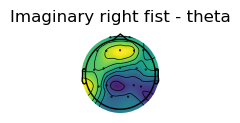

<Figure size 640x480 with 0 Axes>

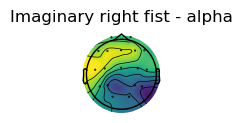

<Figure size 640x480 with 0 Axes>

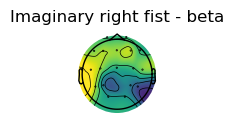

<Figure size 640x480 with 0 Axes>

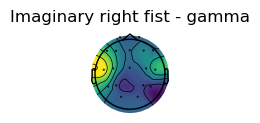

<Figure size 640x480 with 0 Axes>

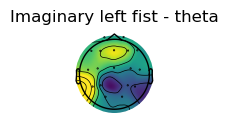

<Figure size 640x480 with 0 Axes>

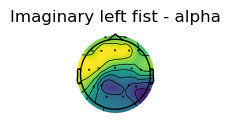

<Figure size 640x480 with 0 Axes>

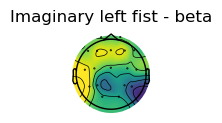

<Figure size 640x480 with 0 Axes>

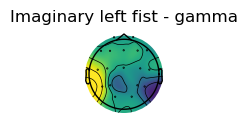

<Figure size 640x480 with 0 Axes>

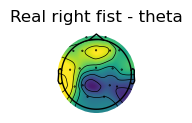

<Figure size 640x480 with 0 Axes>

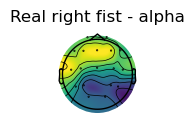

<Figure size 640x480 with 0 Axes>

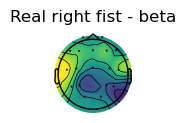

<Figure size 640x480 with 0 Axes>

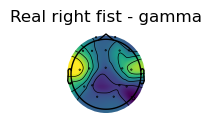

<Figure size 640x480 with 0 Axes>

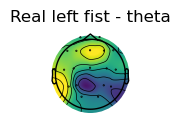

<Figure size 640x480 with 0 Axes>

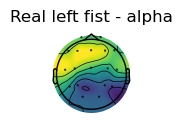

<Figure size 640x480 with 0 Axes>

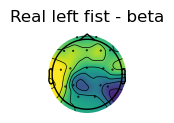

<Figure size 640x480 with 0 Axes>

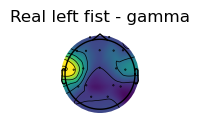

In [15]:
# Step 4: Plot these power values in topomaps, separate for each condition
info = epochs_Iright.info  # Assuming all epochs have the same channel info

for cond_name, band_power in band_power_by_condition.items():
    for band_name, power_values in band_power.items():
        plt.figure()
        # Create the topomap plot
        mne.viz.plot_topomap(power_values, info, show=False, cmap='viridis')
        # Add a title using plt.title()
        plt.title(f'{cond_name} - {band_name}')
        plt.show()


<Figure size 640x480 with 0 Axes>

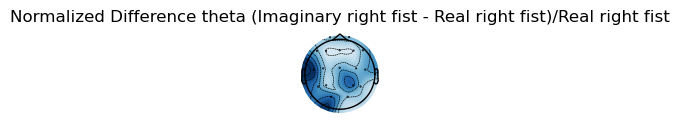

<Figure size 640x480 with 0 Axes>

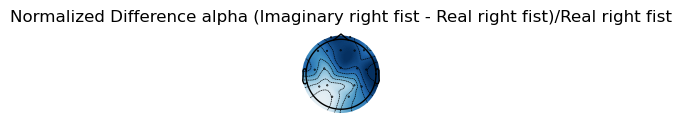

<Figure size 640x480 with 0 Axes>

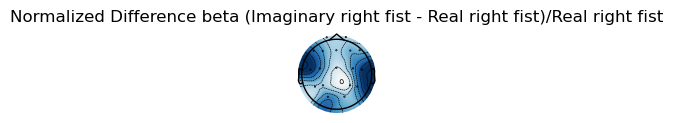

<Figure size 640x480 with 0 Axes>

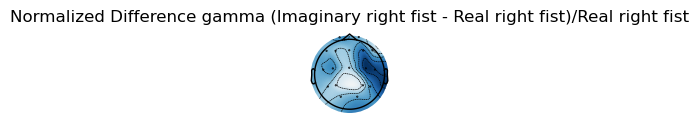

<Figure size 640x480 with 0 Axes>

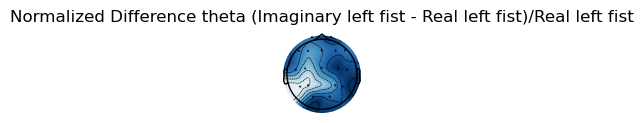

<Figure size 640x480 with 0 Axes>

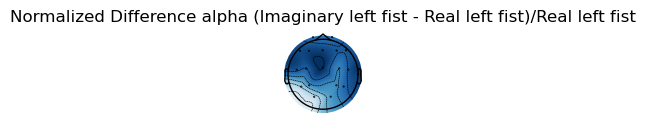

<Figure size 640x480 with 0 Axes>

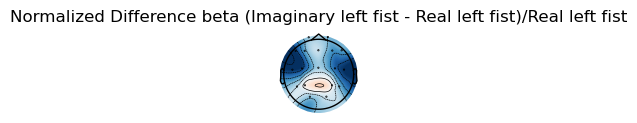

<Figure size 640x480 with 0 Axes>

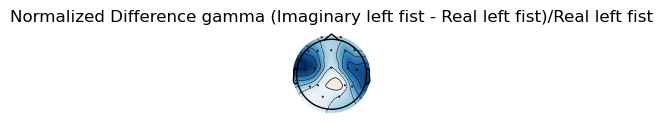

<Figure size 640x480 with 0 Axes>

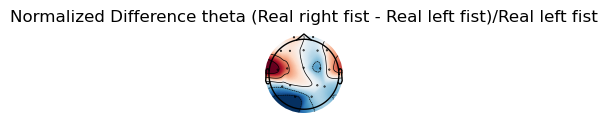

<Figure size 640x480 with 0 Axes>

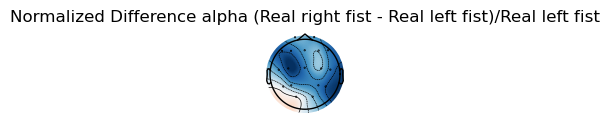

<Figure size 640x480 with 0 Axes>

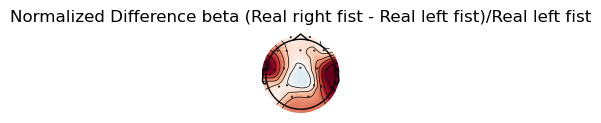

<Figure size 640x480 with 0 Axes>

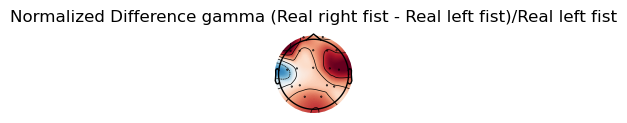

<Figure size 640x480 with 0 Axes>

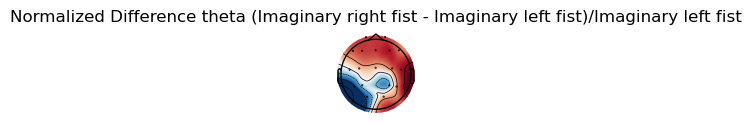

<Figure size 640x480 with 0 Axes>

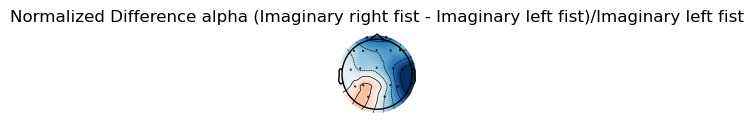

<Figure size 640x480 with 0 Axes>

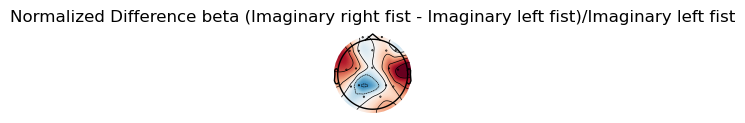

<Figure size 640x480 with 0 Axes>

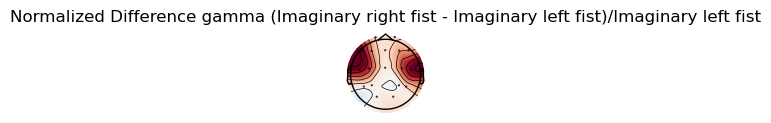

In [16]:
# Step 5: Plot normalized differences topomaps (A-B)/B
comparisons = [
    ('Imaginary right fist', 'Real right fist'),
    ('Imaginary left fist', 'Real left fist'),
    ('Real right fist', 'Real left fist'),
    ('Imaginary right fist', 'Imaginary left fist')
]
for cond_A, cond_B in comparisons:
    for band_name in bands.keys():
        power_A = band_power_by_condition[cond_A][band_name]
        power_B = band_power_by_condition[cond_B][band_name]
        norm_diff = (power_A - power_B) / power_B  # Normalized difference

        # Plot the normalized difference
        plt.figure()
        vmin, vmax = -np.max(np.abs(norm_diff)), np.max(np.abs(norm_diff))
        mne.viz.plot_topomap(
            norm_diff, info, show=False, cmap='RdBu_r',
            vmin=vmin, vmax=vmax)
        plt.title(f'Normalized Difference {band_name} ({cond_A} - {cond_B})/{cond_B}')
        plt.show()
